In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import warnings

from sympy import use

warnings.simplefilter('ignore')

sys.path.append('../utilities')
sys.path.append('../models/grt123')
sys.path.append('../models/grt123/training')
sys.path.append('../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation

workspace_path = os.path.join(os.getcwd(), '..')

LUNA_EXCLUSIONS_PATH = Path(f'{workspace_path}/data/LUNA/metadata/annotations_excluded.csv')
LUNA_GRT_EXCLUSIONS = Path(f'{workspace_path}/data/LUNA/metadata/grt123_annotations_excluded.csv')


exclude_recode = {
    'seriesuid' : 'name',
    'coordX' : 'row',
    'coordY' : 'col',
    'coordZ' : 'index',
    'diameter_mm' : 'diameter'
}

# GRT 123 - Trained LUNA Evaluated on LUNA

## Utility functions

In [2]:
def get_scans_path(scans_path, working_path, folds=True):

    if folds:
        scans_paths = Path(scans_path).rglob('**/validation_scans.csv')
        scan_ids = pd.concat([pd.read_csv(scan_path) for scan_path in scans_paths]).scan_id
    else:
        scan_ids = pd.read_csv(scans_path).scan_id

    scan_ids.to_csv(working_path / 'scanlist.csv', index=False)
    return working_path / 'scanlist.csv'

def get_annotations_path(metadata_path, working_path, recode={}):

    metadata = pd.read_csv(metadata_path).rename(columns=recode)

    metadata.to_csv(working_path / 'annotations.csv', index=False)


    return working_path / 'annotations.csv'


def get_predictions_path(predictions_path, working_path, recode={}):

    predictions = pd.read_csv(predictions_path).rename(columns=recode)

    predictions.to_csv(working_path / 'predictions.csv', index=False)

    return working_path / 'predictions.csv'


def get_exclusions_path(exclusions_path, working_path, recode={}):

    exclusions = pd.read_csv(exclusions_path).rename(columns=recode)

    exclusions.to_csv(working_path / 'exclusions.csv', index=False)

    return working_path / 'exclusions.csv'


## Arm 1: Balanced combination of Positive and Negative samples

/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/grt123/bbox_result/trained_luna/luna/arm1/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: bootstrap 22/1

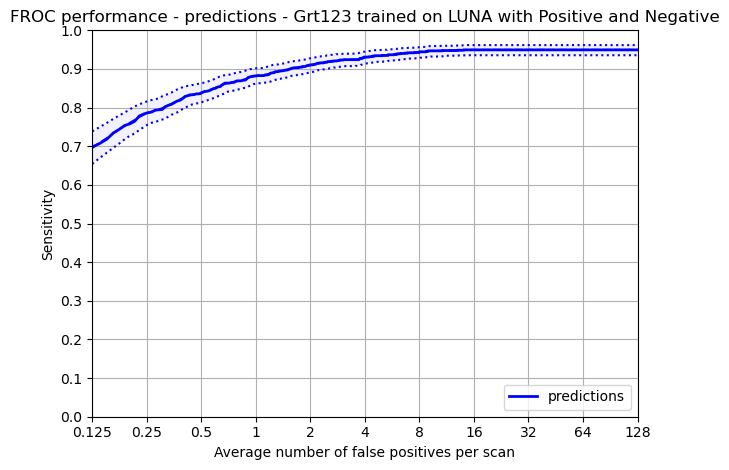

In [3]:
# arm 1

scans_path = get_scans_path(
    Path(f'{workspace_path}/metadata/LUNA/arm1'),
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1')
)

annotations_path = get_annotations_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1_metadata.csv'),
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1')
)

predictions_path = get_predictions_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1_predictions.csv'),
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1')
)

exclusions_path = get_exclusions_path(
    LUNA_GRT_EXCLUSIONS,
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1')
)

grt123_luna_on_luna_arm1 = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,    
    filter='Grt123 trained on LUNA with Positive and Negative',
    outputDir=f'{workspace_path}/results/grt123/trained_luna/luna/arm1',
)

## Arm 2: Trained with just Positive samples

/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/grt123/bbox_result/trained_luna/luna/arm2/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: bootstrap 22/1

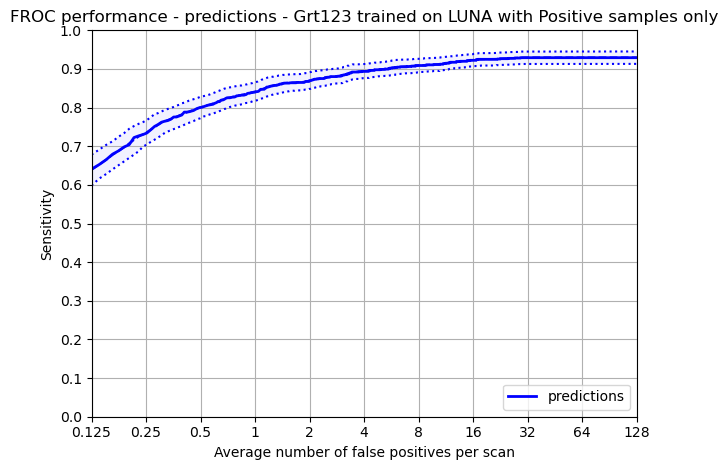

In [4]:
# arm 2

scans_path = get_scans_path(
    Path(f'{workspace_path}/metadata/LUNA/arm1'),
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm2')
)

annotations_path = get_annotations_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1_metadata.csv'),
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm2')
)

predictions_path = get_predictions_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm2_predictions.csv'),
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm2')
)

exclusions_path = get_exclusions_path(
    LUNA_GRT_EXCLUSIONS,
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm2')
)

grt123_luna_on_luna_arm2 = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,    
    filter='Grt123 trained on LUNA with Positive samples only',
    outputDir=f'{workspace_path}/results/grt123/trained_luna/luna/arm2',
)

# GRT 123 Trained LUNA Evaluated on SUMMIT

In [5]:
def get_summit_annotations_from_metadata(metadata_path, recode={}):

    working_path = Path(metadata_path).parent

    annotations = pd.read_csv(metadata_path).rename(columns=recode)
    annotations = annotations[~annotations.radiology_report_lesions_to_exclude]
    annotations.to_csv(working_path / 'annotations.csv', index=False)

    exclusions = annotations[annotations.radiology_report_lesions_to_exclude]
    exclusions.to_csv(working_path / 'exclusions.csv', index=False)

    return working_path / 'annotations.csv', working_path / 'exclusions.csv'

## Inference Using Arm1 - Positive & Negative Training Samples

/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/grt123/bbox_result/trained_luna/summit/partial/arm1/metadata.csv
Total number of included nodule annotations: 1082
Total number of nodule annotations: 1082
Cases: 798
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: bootstra

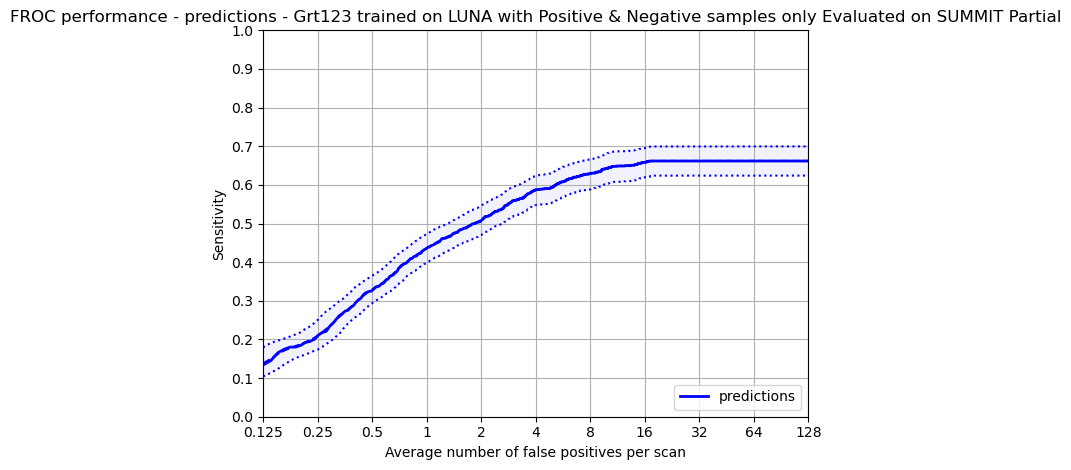

In [24]:
scans_path = f"{workspace_path}/metadata/SUMMIT/partial/test_scans.csv"

annotations_path = f"{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm1/metadata.csv"

exlusions_path = f"{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/summit_exclusions.csv"

predictions_path = f"{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm1/predictions.csv"

grt123_luna_on_summit_partial = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,    
    filter='Grt123 trained on LUNA with Positive & Negative samples only Evaluated on SUMMIT Partial',
    outputDir=f'{workspace_path}/results/grt123/trained_luna/summit/partial/arm1',
)

## Inference Using Arm2 - Positive & Negative Training Samples

/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/grt123/bbox_result/trained_luna/summit/partial/arm2/annotations.csv
Total number of included nodule annotations: 1082
Total number of nodule annotations: 1082
Cases: 798
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: boots

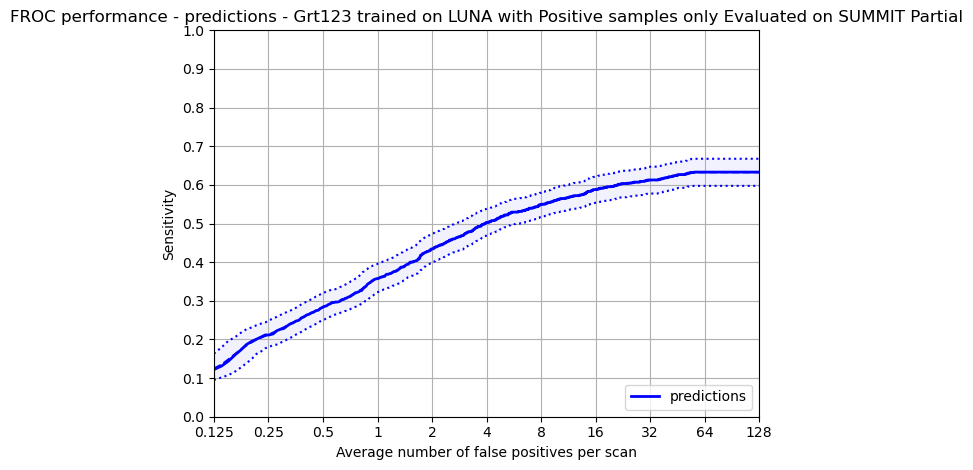

In [7]:

scans_path          = f"{workspace_path}/metadata/SUMMIT/partial/test_scans.csv"

annotations_path, exclusions_path = get_summit_annotations_from_metadata(f"{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm2/metadata.csv")

predictions_path    = f"{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm2/predictions.csv"

grt123_luna_on_summit_partial = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,    
    filter='Grt123 trained on LUNA with Positive samples only Evaluated on SUMMIT Partial',
    outputDir=f'{workspace_path}/results/grt123/trained_luna/summit/partial/arm2',
)

# Detection - Trained LUNA Evaluated LUNA

## Utility functions

In [8]:

def iou(box0, box1):
    r0 = box0[3] / 2
    s0 = box0[:3] - r0
    e0 = box0[:3] + r0

    r1 = box1[3] / 2
    s1 = box1[:3] - r1
    e1 = box1[:3] + r1

    overlap = []
    for i in range(len(s0)):
        overlap.append(max(0, min(e0[i], e1[i]) - max(s0[i], s1[i])))

    intersection = overlap[0] * overlap[1] * overlap[2]
    union = box0[3] * box0[3] * box0[3] + box1[3] * box1[3] * box1[3] - intersection
    return intersection / union

def nms(predictions, overlap_threshold=0.1):
    """
    Non-maximum suppression

    Args:
    predictions (pd.DataFrame): dataframe of predictions
    overlap_threshold (float): threshold for overlap

    Returns:
    nms_predictions (pd.DataFrame): dataframe of nms predictions
    
    """

    nms_predictions = pd.DataFrame(columns=predictions.columns)

    while len(predictions) > 0:
        max_idx = predictions['threshold'].idxmax()
        max_row = predictions.loc[max_idx]

        nms_predictions = nms_predictions.append(max_row)

        predictions = predictions.drop(max_idx)

        for idx, row in predictions.iterrows():
            
            overlap = iou(
                    max_row[['row', 'col', 'index', 'diameter']].values, 
                    row[['row', 'col', 'index', 'diameter']].values
                )
            
            if overlap > overlap_threshold:
                predictions = predictions.drop(idx)

    return nms_predictions

def get_scans_path(metadata_csv_path, results_dir, recode={}):
    scans_list = []
    for scans_path in metadata_csv_path.rglob('validation_scans.csv'):
        scans_list.append(pd.read_csv(scans_path))

    scans = pd.concat(scans_list, ignore_index=True)
    print('Number of scans:',scans.shape)

    scans_filepath = results_dir / 'scanlist.csv'
    scans.to_csv(scans_filepath, index=False)

    return scans.scan_id, scans_filepath    

def get_annotations_path(metadata_csv_path, results_dir, recode={}):
    """
    Convert metadata to annotation file

    Args:
    metadata_csv_path (str): path to metadata csv
    scan_ids (list): list of scan ids
    results_dir (str): path to results directory
    recode (dict): dictionary to rename columns

    Returns:
    annotations_filepath (str): path to annotations csv
    
    """

    annotations_list = []
    
    for metadata_csv_path in metadata_csv_path.rglob('validation_annotations.csv'):
        annotations_list.append(pd.read_csv(metadata_csv_path).rename(columns=recode))

    annotations = pd.concat(annotations_list, ignore_index=True)
    print('Number of nodules:',annotations.shape)

    annotations_filepath = results_dir / 'annotations.csv'
    annotations.to_csv(annotations_filepath, index=False)

    return annotations_filepath

def get_exclusions_path(metadata_csv_path, scan_ids, results_dir, recode={}):
    """
    Convert metadata to exclusion file

    Args:
    metadata_csv_path (str): path to metadata csv
    scan_ids (list): list of scan ids
    results_dir (str): path to results directory
    recode (dict): dictionary to rename columns

    Returns:
    exclusions_filepath (str): path to exclusions csv
    
    """

    exclusions = pd.read_csv(metadata_csv_path).rename(columns=recode)
    exclusions = exclusions[exclusions['name'].isin(scan_ids)]

    exclusions_filepath = results_dir / 'exclusions.csv'
    exclusions.to_csv(exclusions_filepath, index=False)

    return exclusions_filepath

def combine_predictions(predictions_json_path, results_dir, dataset_name, use_nms=True):
    """
    Get predictions from a json file

    Args:
    predictions_json_path: str, path to the json file

    Returns:
    images: list of str, list of image names
    predictions: pd.DataFrame, dataframe of predictions
    
    """
    predictions_list = []

    for prediction_json_path in predictions_json_path.glob('*json'):
        
        print(prediction_json_path)

        with open(prediction_json_path,'r') as f:
            predictions_json = json.load(f)

        idx = 0
        for image_cnt, image in enumerate(predictions_json[dataset_name]):
            name = image['image'].split('/')[-1][:-7]
            
            image_predictions_dict = {}
            for box, score in zip(image['box'], image['score']):
                prediction = {}
                prediction['threshold'] = score
                prediction['index'] = box[2]
                prediction['col'] = box[1]
                prediction['row'] = box[0]
                prediction['diameter'] = np.max(box[3:])
                prediction['name'] = name

                image_predictions_dict[idx] = prediction
                idx+=1
            
            image_predictions = pd.DataFrame.from_dict(image_predictions_dict, orient='index')
            if image_cnt == 0 and use_nms:
                print(image_predictions.shape)
                print('after nms')
                print(nms(image_predictions).shape)

            if use_nms:
                predictions_list.append(nms(image_predictions))
            else:
                predictions_list.append(image_predictions)

    predictions = pd.concat(predictions_list, ignore_index=True)
    predictions.to_csv(results_dir / 'predictions.csv', index=False)

    return results_dir / 'predictions.csv'


## Arm 1: Balanced combination of Positive and Negative samples

Number of scans: (888, 1)
Number of nodules: (1186, 5)
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm1/result_fold5.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm1/result_fold4.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm1/result_fold3.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm1/result_fold2.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm1/result_fold1.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm1/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
comp

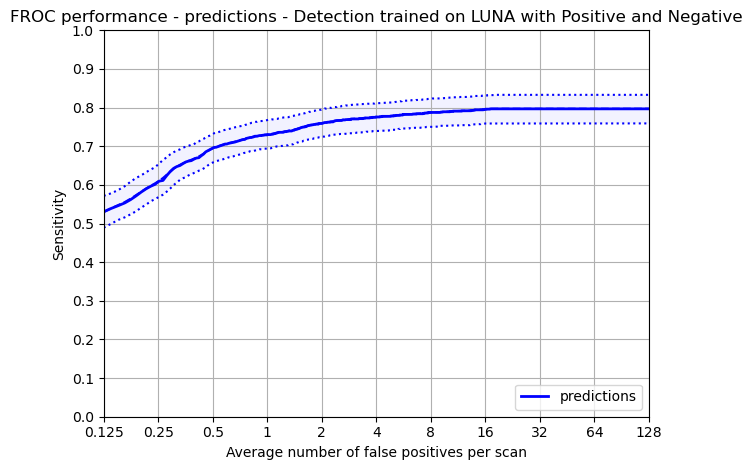

In [9]:
results_output_path = Path(f'{workspace_path}/results/detection/trained_luna/luna/arm1')
results_output_path.mkdir(parents=True, exist_ok=True)

model_results_path  = Path(f'{workspace_path}/models/detection/result/trained_luna/LUNA/arm1')
model_results_path.mkdir(parents=True, exist_ok=True)


scan_ids, scanlist_filepath = get_scans_path(
                            metadata_csv_path=Path(f'{workspace_path}/metadata/LUNA/arm1'),
                            results_dir=model_results_path
                        )


annotations_filepath = get_annotations_path(
                            metadata_csv_path=Path(f'{workspace_path}/metadata/LUNA/arm1'),
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

exclusions_filepath = get_exclusions_path(
                            metadata_csv_path=LUNA_EXCLUSIONS_PATH,
                            scan_ids=scan_ids,
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

predictions_filepath = combine_predictions(
                            predictions_json_path=Path(model_results_path),
                            results_dir=model_results_path,
                            dataset_name='test',
                            use_nms=False
                        )

detection_luna_on_luna_arm1 = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,    
    filter='Detection trained on LUNA with Positive and Negative',
    outputDir=results_output_path
)

## Arm 2: Trained with just Positive samples

Number of scans: (888, 1)
Number of nodules: (1186, 5)
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm2/result_fold5.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm2/result_fold4.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm2/result_fold3.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm2/result_fold2.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm2/result_fold1.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/LUNA/arm2/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
comp

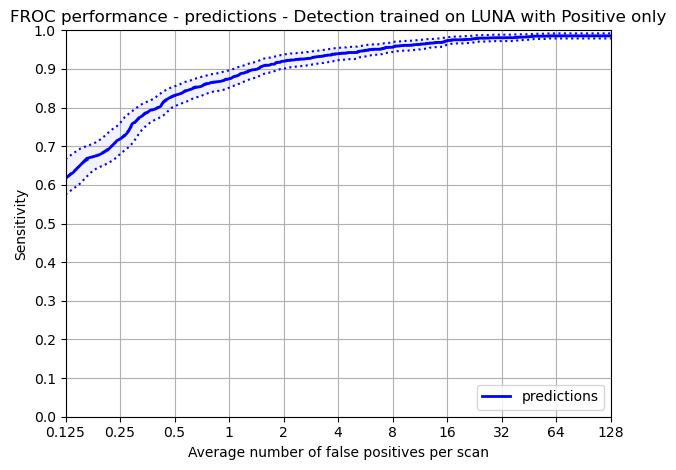

In [10]:
results_output_path = Path(f'{workspace_path}/results/detection/trained_luna/luna/arm2')
results_output_path.mkdir(parents=True, exist_ok=True)

model_results_path  = Path(f'{workspace_path}/models/detection/result/trained_luna/LUNA/arm2')
model_results_path.mkdir(parents=True, exist_ok=True)


scan_ids, scanlist_filepath = get_scans_path(
                            metadata_csv_path=Path(f'{workspace_path}/metadata/LUNA/arm1'),
                            results_dir=model_results_path
                        )


annotations_filepath = get_annotations_path(
                            metadata_csv_path=Path(f'{workspace_path}/metadata/LUNA/arm1'),
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

exclusions_filepath = get_exclusions_path(
                            metadata_csv_path=LUNA_EXCLUSIONS_PATH,
                            scan_ids=scan_ids,
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

predictions_filepath = combine_predictions(
                            predictions_json_path=Path(model_results_path),
                            results_dir=model_results_path,
                            dataset_name='test',
                            use_nms=False
                        )

detection_luna_on_luna_arm2 = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,    
    filter='Detection trained on LUNA with Positive only',
    outputDir=results_output_path
)

# Detection - Trained LUNA evaluated on SUMMIT

In [11]:
from numpy import rec


def get_summit_scans_path(scanlist_filepath, working_path, folds=True):
    """
    Get scans path for summit

    Args:
    scanlist_filepath (str): path to scanlist csv
    working_path (str): path to working directory
    folds (bool): whether to use folds

    Returns:
    scans_path (str): path to scans csv
    
    """

    scan_ids = pd.read_csv(scanlist_filepath).scan_id

    scan_ids.to_csv(working_path / 'scanlist.csv', index=False)
    return working_path / 'scanlist.csv'

def get_summit_annotations_path(annotations_filepath, working_path, recode={}):
    """
    Get annotations path for summit

    Args:
    annotations_filepath (str): path to annotations csv
    working_path (str): path to working directory
    recode (dict): dictionary to rename columns

    Returns:
    annotations_path (str): path to annotations csv
    
    """

    annotations = (
        pd.read_csv(annotations_filepath)
        .rename(columns=recode)
        .assign(threshold=-1000000)
        .assign(scan_id=lambda df: df.participant_id + '_Y0_BASELINE_A')
    ).rename(columns=recode)

    annotations.to_csv(working_path / 'annotations.csv', index=False)

    return working_path / 'annotations.csv'


def get_summit_exclusions_path(exclusions_filepath, working_path, recode={}):
    """
    Get exclusions path for summit

    Args:
    exclusions_filepath (str): path to exclusions csv
    working_path (str): path to working directory
    recode (dict): dictionary to rename columns

    Returns:
    exclusions_path (str): path to exclusions csv
    
    """

    exclusions = (
        pd.read_csv(exclusions_filepath)
        .rename(columns=recode)
        .assign(threshold=-1000000)
        .assign(scan_id=lambda df: df.participant_id + '_Y0_BASELINE_A')
    ).rename(columns=recode)

    exclusions.to_csv(working_path / 'exclusions.csv', index=False)

    return working_path / 'exclusions.csv'

def get_summit_predictions_path_from_json(results_json_path, working_path):
    """
    Get predictions path for summit

    Args:
    results_json_path (str): path to results json
    working_path (str): path to working directory
    recode (dict): dictionary to rename columns

    Returns:
    predictions_path (str): path to predictions csv
    
    """

    with open(results_json_path,'r') as f:
        predictions_json = json.load(f)

    idx = 0

    image_predictions_dict = {}
    for image in predictions_json['test']:
        name = image['image'].split('/')[-1][:-7]

        for box, score in zip(image['box'], image['score']):
            prediction = {}
            prediction['threshold'] = score
            prediction['index'] = box[2]
            prediction['col'] = box[1]
            prediction['row'] = box[0]
            prediction['diameter'] = np.max(box[3:])
            prediction['name'] = name

            image_predictions_dict[idx] = prediction
            idx+=1
        
    pd.DataFrame.from_dict(image_predictions_dict, orient='index').to_csv(working_path / 'predictions.csv', index=False)
    return working_path / 'predictions.csv'

/Users/john/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/SUMMIT/partial/annotations.csv
Total number of included nodule annotations: 1082
Total number of nodule annotations: 1292
Cases: 798
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-5729-yex_Y0_BASELINE_A, nodule Annot ID: None
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
compu

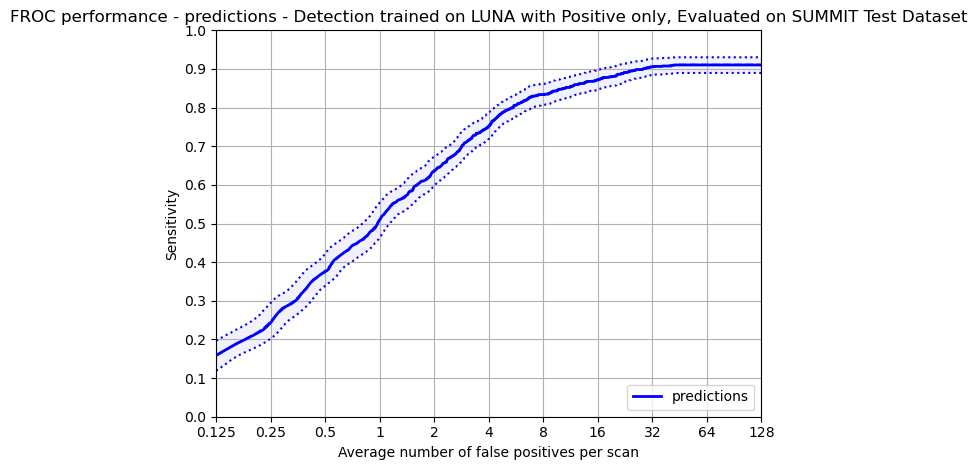

In [12]:
results_output_path = Path(f'{workspace_path}/results/detection/trained_luna/summit/partial')
results_output_path.mkdir(parents=True, exist_ok=True)


metadata_recode = {
        'scan_id':'name',
        'nodule_x_coordinate':'row',
        'nodule_y_coordinate':'col',
        'nodule_z_coordinate':'index',
        'nodule_diameter_mm':'diameter'
}

scanlist_filepath = get_summit_scans_path(Path(f'{workspace_path}/metadata/SUMMIT/partial/test_scans.csv'),
                                   Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial'))

annotations_filepath = get_summit_annotations_path(Path(f'{workspace_path}/metadata/SUMMIT/partial/test_metadata.csv'),
                                                   Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial'),
                                                   recode=metadata_recode)

exclusions_filepath = get_summit_exclusions_path(Path(f'{workspace_path}/metadata/SUMMIT/partial/test_excludes.csv'),
                                                Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial'),
                                                recode=metadata_recode)

predictions_filepath = get_summit_predictions_path_from_json(Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial/result_partial.json'),
                                                             Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial'))

detection_luna_on_summit_partial = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,    
    filter='Detection trained on LUNA with Positive only, Evaluated on SUMMIT Test Dataset',
    outputDir=results_output_path
)



In [13]:
fps = grt123_luna_on_luna_arm1[0]
tpr = grt123_luna_on_luna_arm1[1]
thresholds = grt123_luna_on_luna_arm1[2]


idx = []
fp = []
th  = []
for rate in [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]:
    absolute_differences = np.abs(fps - rate)
    closest_index = np.argmin(absolute_differences)
    idx.append(closest_index)
    th.append(thresholds[closest_index])
    fp.append(fps[closest_index])

print(idx)
print(fp)
print(th)

[187, 301, 397, 491, 557, 605, 639, 661, 661, 661, 661]
[0.12485939257592801, 0.24746906636670415, 0.49943757030371205, 1.015748031496063, 1.9842519685039368, 3.9595050618672665, 7.995500562429696, 14.094488188976378, 14.094488188976378, 14.094488188976378, 14.094488188976378]
[5.590331, 5.108508, 4.5284595, 3.8143363, 2.788436, 1.3970709, 0.12122488, -0.9999039, -0.9999039, -0.9999039, -0.9999039]


# Miss Analysis

## Utility functions

In [55]:
grt123_misses = (
    pd.read_csv(f'{workspace_path}/results/grt123/trained_luna/summit/partial/arm1/nodulesWithoutCandidate_predictions.txt', header=None)
    .rename(columns={0:'name',
                     1:'idx',
                     2:'col',
                     3:'row',
                     4:'index',
                     5:'diameter',
                     6:'threshold'})
    .assign(miss=True)
    .assign(index=lambda df: df['index'].astype(int))
    .assign(row=lambda df: df['row'].astype(int))
    .assign(col=lambda df: df['col'].astype(int))
    .assign(diameter=lambda df: df['diameter'].astype(int))
)

display(grt123_misses.shape)

metadata = (
    pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm1/metadata.csv')
    .assign(index=lambda df: df['index'].astype(int))
    .assign(row=lambda df: df['row'].astype(int))
    .assign(col=lambda df: df['col'].astype(int))
    .assign(diameter=lambda df: df['diameter'].astype(int))
)

grt123_misses = metadata.merge(grt123_misses, on=['name','index','row','col','diameter'], how='left')
grt123_misses.miss.fillna(False, inplace=True)
display(grt123_misses.miss.value_counts())


(366, 8)

False    716
True     366
Name: miss, dtype: int64

In [49]:
detection_misses = (
    pd.read_csv(f'{workspace_path}/results/detection/trained_luna/summit/partial/nodulesWithoutCandidate_predictions.txt', header=None)
    .rename(columns={0:'name',
                     1:'idx',
                     2:'col',
                     3:'row',
                     4:'index',
                     5:'diameter',
                     6:'threshold'})
    .assign(index=lambda df: df['index'].astype(int))
    .assign(row=lambda df: df['row'].astype(int))
    .assign(col=lambda df: df['col'].astype(int))
    .assign(diameter=lambda df: df['diameter'].astype(int))                     
    .assign(miss=True)
)


metadata = (
    pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_metadata.csv')
    .assign(index=lambda df: df['nodule_z_coordinate'].astype(int))
    .assign(row=lambda df: df['nodule_x_coordinate'].astype(int))
    .assign(col=lambda df: df['nodule_y_coordinate'].astype(int))
    .assign(diameter=lambda df: df['nodule_diameter_mm'].astype(int))
    .assign(name=lambda df: df['participant_id'] + '_Y0_BASELINE_A')
)

salient_vars = ['name','index','row','col','diameter']

detection_misses = metadata.merge(detection_misses, on=['name','index','row','col','diameter'], how='left')
detection_misses.miss.fillna(False, inplace=True)

display(detection_misses.miss.value_counts())

False    985
True      97
Name: miss, dtype: int64

In [118]:
grt123_misses.columns

Index(['id', 'form_instance_id', 'form_instance_status', 'participant_id',
       'form_instance_index', 'nodule_brock_score', 'nodule_category',
       'nodule_diameter_mm', 'nodule_lesion_id', 'nodule_lung_rads',
       'nodule_mass', 'nodule_mass_core', 'nodule_mass_double_time_core',
       'nodule_mass_doubling_time', 'nodule_reliable_segment', 'nodule_site',
       'nodule_size_volume_cub_mm', 'nodule_slice_number',
       'nodule_spiculation', 'nodule_subsolid_major_axis_diameter',
       'nodule_type', 'nodule_volume_core', 'nodule_volume_doubling_time',
       'nodule_volume_percentage_change',
       'nodule_volume_volume_double_time_core', 'nodule_x_coordinate',
       'nodule_y_coordinate', 'nodule_z_coordinate',
       'radiology_report_management_plan_value', 'management_plan',
       'radiology_report_malignancy_diagnosis',
       'radiology_report_malignancy_criteria',
       'radiology_report_malignancy_primary_order',
       'radiology_report_scans_transfer_state', 'g

********************************************************************************
nodule_type
********************************************************************************


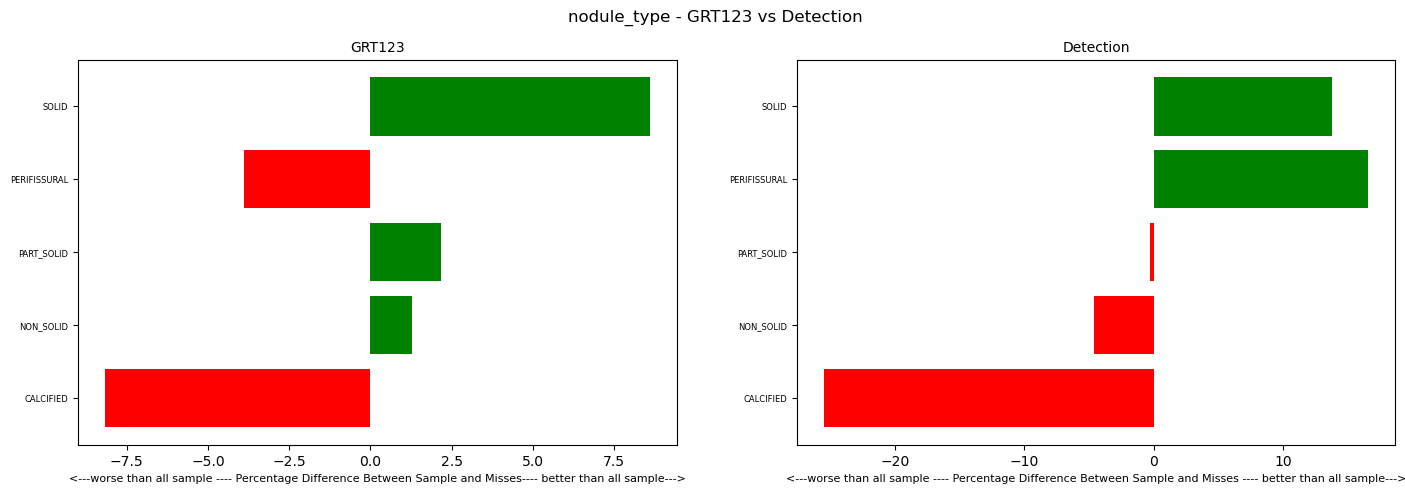

********************************************************************************
nodule_lung_rads
********************************************************************************


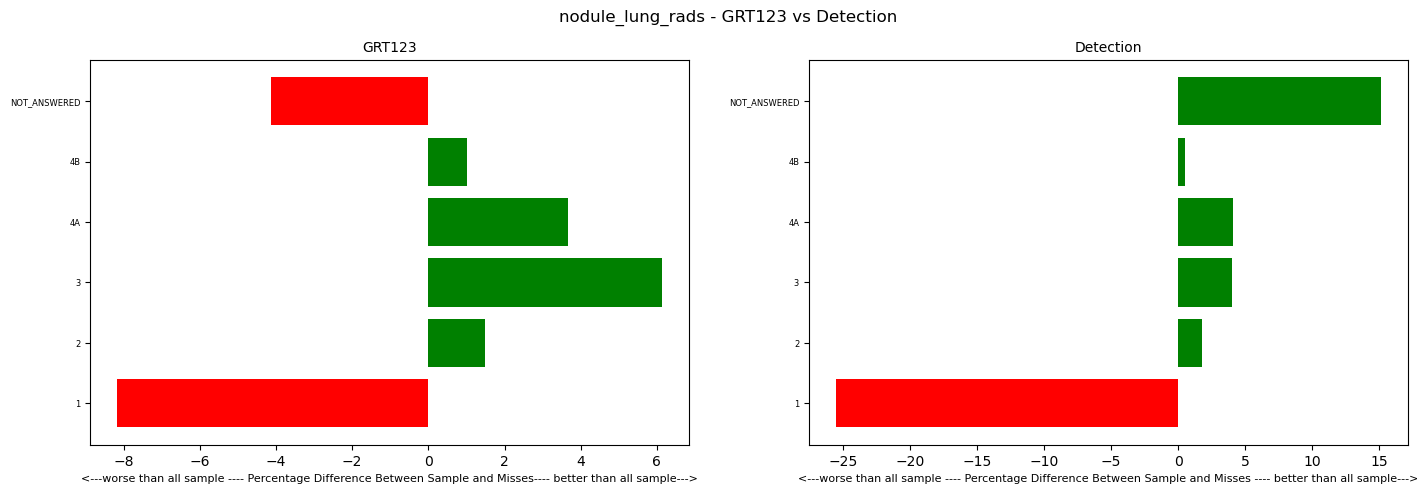

********************************************************************************
nodule_site
********************************************************************************


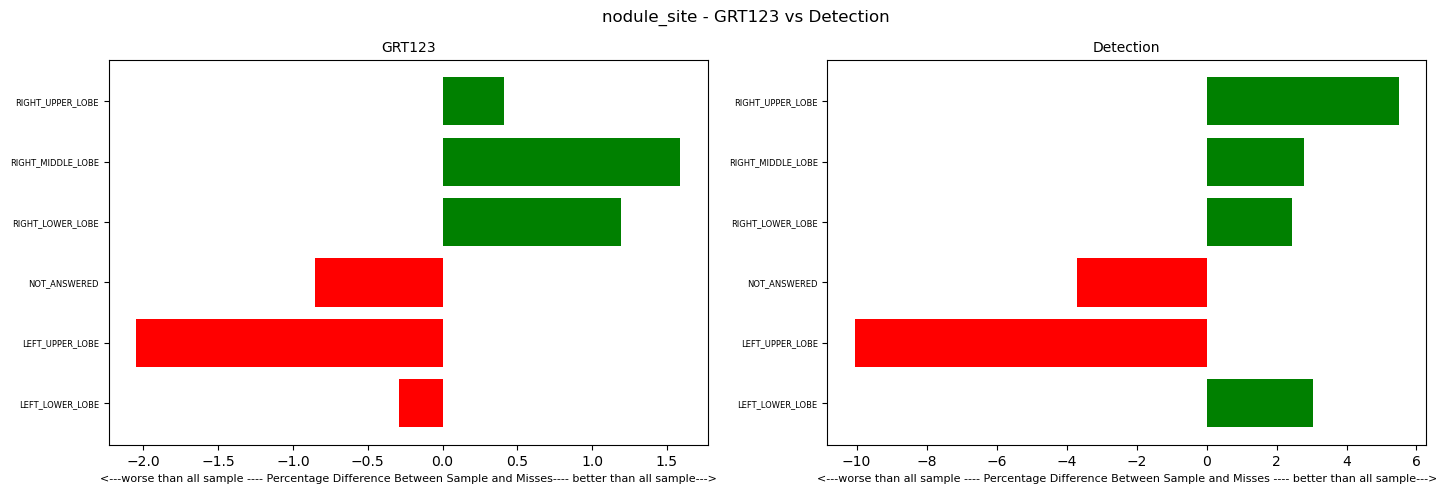

********************************************************************************
management_plan
********************************************************************************


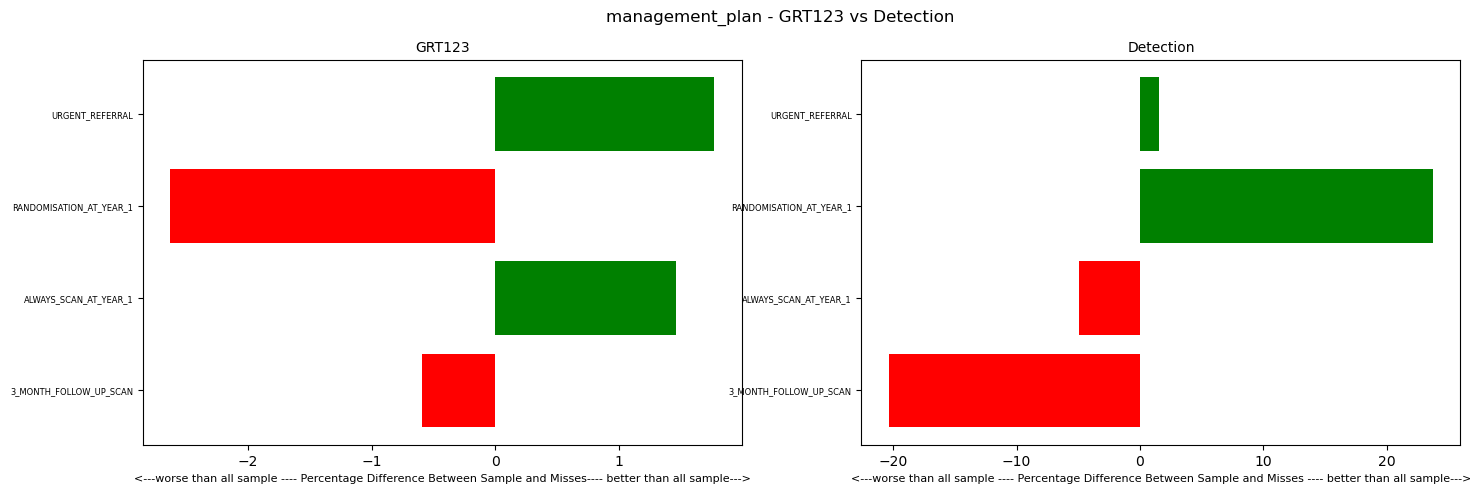

********************************************************************************
nodule_diameter_mm
********************************************************************************


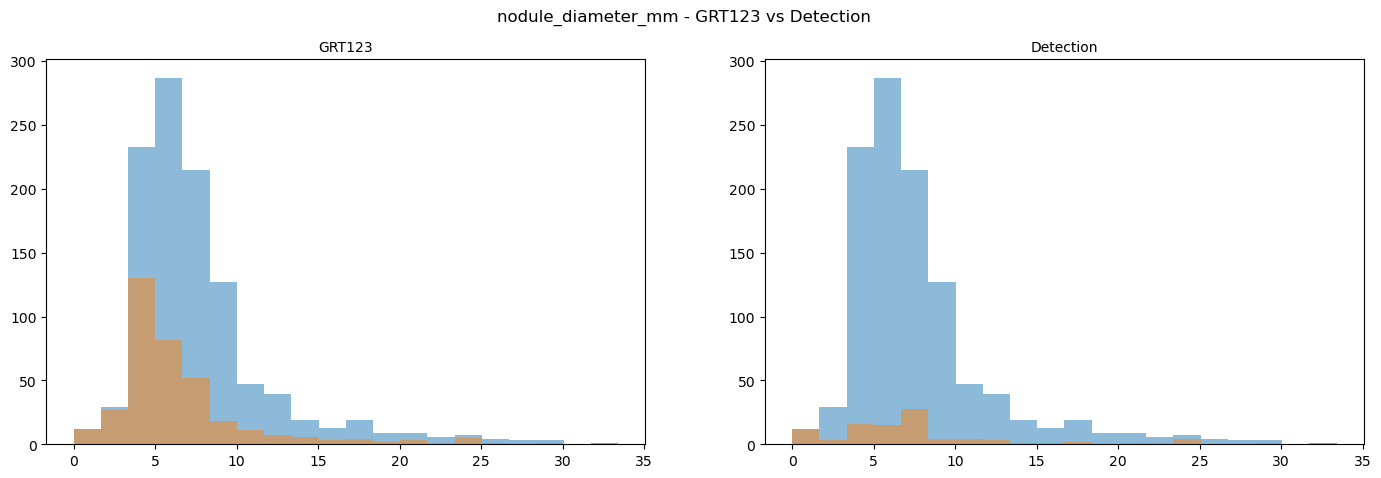

********************************************************************************
nodule_volume_mm3
********************************************************************************


KeyError: 'nodule_volume_mm3'

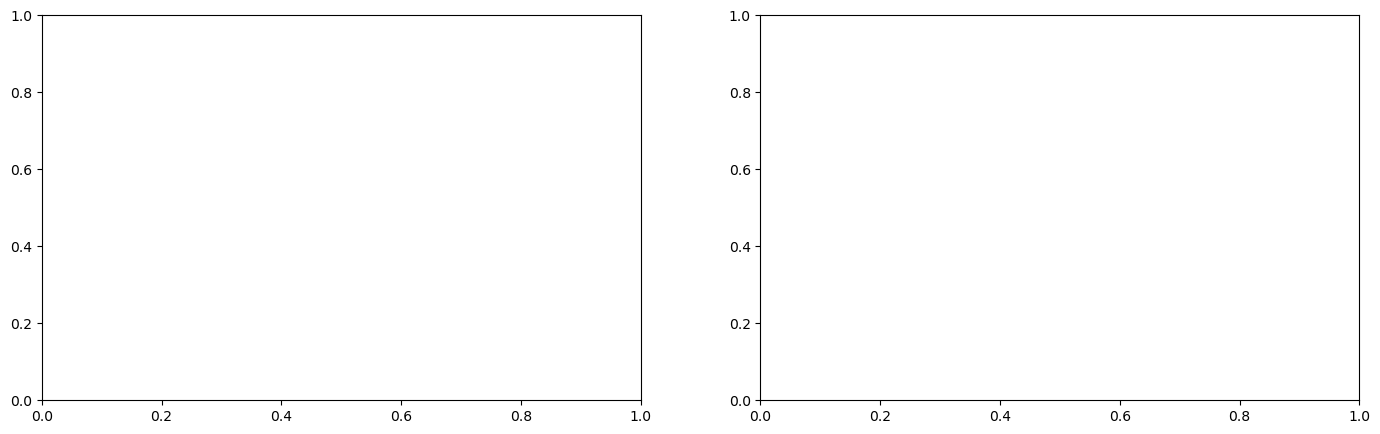

In [117]:
categorical_variables_to_investigate = ['nodule_type','nodule_lung_rads','nodule_site','management_plan']

for var in categorical_variables_to_investigate:

    print('*'*80)
    print(var)
    print('*'*80)

    x = (
        pd.DataFrame(grt123_misses[var].value_counts(normalize=True)).merge(
        pd.DataFrame(grt123_misses[grt123_misses.miss][var].value_counts(normalize=True)),
        how='outer',
        left_index=True,
        right_index=True,
        suffixes=('_all','_miss')
        ).assign(difference=lambda df: df[var+'_all'] - df[var+'_miss']).applymap(lambda x: f'{x:.2%}')
    ).sort_index()

    y = (
        pd.DataFrame(detection_misses[var].value_counts(normalize=True)).merge(
        pd.DataFrame(detection_misses[detection_misses.miss][var].value_counts(normalize=True)),
        how='outer',
        left_index=True,
        right_index=True,
        suffixes=('_all','_miss')
        ).assign(difference=lambda df: df[var+'_all'] - df[var+'_miss']).applymap(lambda x: f'{x:.2%}')
    ).sort_index()

    fig, ax = plt.subplots(1, 2, figsize=(17,5))

    # Set the color of bars with negative values to red
    ax[0].barh(x.index, x['difference'].str.rstrip('%').astype(float), color=['red' if val < 0 else 'green' for val in x['difference'].str.rstrip('%').astype(float)], label='All')
    ax[1].barh(y.index, y['difference'].str.rstrip('%').astype(float), color=['red' if val < 0 else 'green' for val in y['difference'].str.rstrip('%').astype(float)], label='All')

    # Reduce the font size of the y-axis labels
    ax[0].tick_params(axis='y', labelsize=6)
    ax[1].tick_params(axis='y', labelsize=6)

    # Add text label below x-axis
    ax[0].set_xlabel('<---worse than all sample ---- Percentage Difference Between Sample and Misses---- better than all sample--->', fontsize=8)
    ax[1].set_xlabel('<---worse than all sample ---- Percentage Difference Between Sample and Misses ---- better than all sample--->', fontsize=8)

    ax[0].set_title('GRT123', fontsize=10)
    ax[1].set_title('Detection', fontsize=10)

    plt.suptitle(f'{var} - GRT123 vs Detection', fontsize=12)
    plt.show()

numeric_variables_to_investigate = ['nodule_diameter_mm', 'nodule_brock_score','nodule_size_volume_cub_mm']

for var in numeric_variables_to_investigate:

    print('*'*80)
    print(var)
    print('*'*80)

    fig, ax = plt.subplots(1, 2, figsize=(17,5))

    ax[0].hist(grt123_misses[var], bins=20, alpha=0.5, label='All')
    ax[0].hist(grt123_misses[grt123_misses.miss][var], bins=20, alpha=0.5, label='Misses')

    ax[1].hist(detection_misses[var], bins=20, alpha=0.5, label='All')
    ax[1].hist(detection_misses[detection_misses.miss][var], bins=20, alpha=0.5, label='Misses')

    ax[0].set_title('GRT123', fontsize=10)
    ax[1].set_title('Detection', fontsize=10)

    plt.suptitle(f'{var} - GRT123 vs Detection', fontsize=12)
    plt.show()